In [2]:
import dask
dask.config.set({"dataframe.query-planning": False})

import scanpy as sc
import spatialdata_io
import numpy as np
import pandas as pd
import sys
import argparse
from pathlib import Path

sys.path.append("../../../workflow/scripts/")
import preprocessing
import readwrite

cfg = readwrite.config()

In [4]:
import dask
dask.config.set({"dataframe.query-planning": False})

import scanpy as sc
import spatialdata_io
import numpy as np
import pandas as pd
import scvi
import sys
import argparse
from pathlib import Path

sys.path.append("../../../workflow/scripts/")
import preprocessing
import readwrite
cfg = readwrite.config()

# Access the arguments
sample_dir = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/breast/0OE1/0OE1')
cell_type_labels = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/cell_type_annotation/10x_0um/breast/breast/0OE1/0OE1/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2/single_cell/labels.parquet')
# cell_type_labels = None
proseg_results_dir = sample_dir / 'raw_results'
xeniumranger_dir = sample_dir / 'normalised_results/outs'


# params from pipeline config
min_counts = 10
min_features = 5
max_counts = float("inf")
max_features = float("inf")
min_cells = 5

mixture_k = 50
max_epochs = 50

adata = readwrite.read_xenium_sample(
    xeniumranger_dir,
    cells_as_circles=False,
    cells_boundaries=False,
    cells_boundaries_layers=False,
    nucleus_boundaries=False,
    cells_labels=False,
    nucleus_labels=False,
    transcripts=False,
    morphology_mip=False,
    morphology_focus=False,
    aligned_images=False,
    anndata=True,
)

# need to round proseg expected counts for resolVI to run
# no need for if statement, doesn't change anything to other segmentation methods
adata.X.data = adata.X.data.astype(np.float32).round()
adata.obs_names = adata.obs_names.astype(str)

if cell_type_labels is not None:
    labels_key = "labels_key"
    semisupervised = True
    adata.obs[labels_key] = pd.read_parquet(cell_type_labels).set_index("cell_id").iloc[:, 0].astype('category')
    adata = adata[adata.obs[labels_key].notna()]
else:
    labels_key = None
    semisupervised = False

# preprocess (QC filters only)
# resolvi requires at least 5 counts in each cell
preprocessing.preprocess(
    adata,
    normalize=False,
    log1p=False,
    scale="none",
    pca=False,
    umap=False,
    save_raw=False,
    min_counts=min_counts,
    min_genes=min_features,
    max_counts=max_counts,
    max_genes=max_features,
    min_cells=min_cells,
    backend="cpu",
)


scvi.external.RESOLVI.setup_anndata(
    adata, labels_key=labels_key, layer=None, prepare_data_kwargs={"spatial_rep": "spatial"}
)
resolvi = scvi.external.RESOLVI(adata, mixture_k=mixture_k, semisupervised=semisupervised)
# resolvi.train(max_epochs=max_epochs)
resolvi.save('model',overwrite=True)

INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                            


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Removed 0  cells...
Removed 0  genes...


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:700: FutureWarning: `transformer='rapids'` is deprecated. Use `rapids_singlecell.tl.neighbors` instead.
  warn(msg, FutureWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [13]:
import dask
dask.config.set({"dataframe.query-planning": False})

import spatialdata_io
import numpy as np
import pandas as pd
import scvi
import sys
import argparse
from pathlib import Path

sys.path.append("../../../workflow/scripts/")
import preprocessing
import readwrite
cfg = readwrite.config()

# Access the arguments
sample_dir = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/breast/0OE1/0OE1')
# cell_type_labels = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/cell_type_annotation/10x_0um/breast/breast/0OE1/0OE1/lognorm/reference_based/matched_reference_combo/rctd_class_aware/Level2/single_cell/labels.parquet')
cell_type_labels = None
proseg_results_dir = sample_dir / 'raw_results'
xeniumranger_dir = sample_dir / 'normalised_results/outs'
dir_resolvi_model= '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_0um/breast/breast/0OE1/0OE1/mixture_k=50/model'
dir_resolvi_model_supervised = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi_supervised/10x_0um/breast/breast/0OE1/0OE1/lognorm/model'

# dir_resolvi_model='model'

# params from pipeline config
min_counts = 10
min_features = 5
max_counts = float("inf")
max_features = float("inf")
min_cells = 5

mixture_k = 50
max_epochs = 50


num_samples=30
batch_size=1000

adata = readwrite.read_xenium_sample(
    xeniumranger_dir,
    cells_as_circles=False,
    cells_boundaries=False,
    cells_boundaries_layers=False,
    nucleus_boundaries=False,
    cells_labels=False,
    nucleus_labels=False,
    transcripts=False,
    morphology_mip=False,
    morphology_focus=False,
    aligned_images=False,
    anndata=True,
)

# need to round proseg expected counts for resolVI to run
# no need for if statement, doesn't change anything to other segmentation methods
adata.X.data = adata.X.data.astype(np.float32).round()
adata.obs_names = adata.obs_names.astype(str)

if cell_type_labels is not None:
    labels_key = "labels_key"
    semisupervised = True
    adata.obs[labels_key] = pd.read_parquet(cell_type_labels).set_index("cell_id").iloc[:, 0].astype('category')
    adata = adata[adata.obs[labels_key].notna()]
else:
    labels_key = None
    semisupervised = False

# preprocess (QC filters only)
# resolvi requires at least 5 counts in each cell
preprocessing.preprocess(
    adata,
    normalize=False,
    log1p=False,
    scale="none",
    pca=False,
    umap=False,
    save_raw=False,
    min_counts=min_counts,
    min_genes=min_features,
    max_counts=max_counts,
    max_genes=max_features,
    min_cells=min_cells,
    backend="cpu",
)



resolvi = scvi.external.RESOLVI.load(dir_resolvi_model, adata=adata)

samples_corr = resolvi.sample_posterior(
    model=resolvi.module.model_corrected,
    return_sites=["obs"],
    return_observed=True,
    summary_fun={"post_donor_q50": np.median},
    num_samples=num_samples,
    batch_size=batch_size,
    summary_frequency=100,
)
samples_corr = pd.DataFrame(samples_corr).T

samples = resolvi.sample_posterior(
    model=resolvi.module.model_residuals,
    return_sites=["mixture_proportions"],
    summary_fun={"post_donor_means": np.mean},
    num_samples=num_samples,
    batch_size=batch_size,
    summary_frequency=100,
)
samples_proportions = pd.DataFrame(samples).T

### save
samples_corr = pd.DataFrame(
    samples_corr.loc["post_donor_q50", "obs"],
    index=adata.obs_names,
    columns=adata.var_names,
)
samples_proportions = pd.DataFrame(
    samples_proportions.loc["post_donor_means", "mixture_proportions"],
    index=adata.obs_names,
    columns=["true_proportion", "diffusion_proportion", "background_proportion"],
)


INFO     reading                                                                                                   
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/b
         reast/0OE1/0OE1/normalised_results/outs/cell_feature_matrix.h5                                            
Removed 11449  cells...
Removed 0  genes...
INFO     File                                                                                                      
         /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/resolvi/10x_0um/breast/breast/0OE1/0OE1/mix
         ture_k=50/model/model.pt already downloaded                                                               


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:185: UserWarning: The table is annotating 'cell_labels', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/minif ...
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:700: FutureWarning: `transformer='rapids'` is deprecated. Use `rapids_singlecell.tl.neighbors` instead.
  warn(msg, FutureWarning)
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib

Epoch 1/50:   2%|▏         | 1/50 [00:00<00:03, 13.93it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/50:   2%|▏         | 1/50 [00:00<00:03, 13.37it/s, v_num=1]

/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/minif ...



Sampling local variables, batch: 100%|██████████| 58/58 [00:48<00:00,  1.19it/s]


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/minif ...


Sampling local variables, batch: 100%|██████████| 58/58 [00:31<00:00,  1.84it/s]


In [30]:
from pomegranate.distributions import Poisson
from pomegranate.gmm import GeneralMixtureModel
from matplotlib.gridspec import GridSpec
from matplotlib import pyplot as plt
import seaborn as sns
import torch
DPI = 100

def double_positive_pmm(adata, marker_list, marker_dict=None, layer_key='counts', output_dir="", file_save='', vmax=0.3):
    if True: # 'positive_pmm_counts' not in adata.obsm:
        adata.obsm['positive_pmm_counts'] = pd.DataFrame(
            0, index=adata.obs_names, columns=marker_list)
        for gene_x in marker_list:
            model = GeneralMixtureModel(
                [Poisson([0.001], inertia=0.99), Poisson([0.5], inertia=0.999)], verbose=False).cuda()
            model_fit = model.fit(
                torch.tensor(adata.obsm['counts'][gene_x].values[..., np.newaxis]).cuda())
            adata.obsm['positive_pmm_counts'][gene_x] = model_fit.predict(torch.tensor(adata.obsm['counts'][gene_x].values[..., np.newaxis]).cuda()).cpu()
    
    adata.obsm[f'positive_pmm_{layer_key}'] = pd.DataFrame(
            0, index=adata.obs_names, columns=marker_list)
    for gene_x in marker_list:
        model = GeneralMixtureModel(
            [Poisson([0.001], inertia=0.99), Poisson([0.5], inertia=0.999)], verbose=False).cuda()
        model_fit = model.fit(
                torch.tensor(adata.obsm[layer_key][gene_x].values[..., np.newaxis]).cuda())
        adata.obsm[f'positive_pmm_{layer_key}'][gene_x] = model_fit.predict(torch.tensor(adata.obsm[layer_key][gene_x].values[..., np.newaxis]).cuda()).cpu()
        
    adata.uns[f'double_positive_{layer_key}'] = pd.DataFrame(
        0, index=marker_list, columns=marker_list)
        
    for ind_x, gene_x in enumerate(marker_list):  
        for ind_y, gene_y in enumerate(marker_list):
            if ind_x<ind_y:
                positives = adata.obsm['positive_pmm_counts'][[gene_x, gene_y]].sum(1)
                adata.uns[f'double_positive_{layer_key}'].loc[gene_x, gene_y] = np.sum(positives==2) / np.sum(positives>0) if np.sum(positives)>0 else None
            else:
                positives = adata.obsm[f'positive_pmm_{layer_key}'][[gene_x, gene_y]].sum(1)
                adata.uns[f'double_positive_{layer_key}'].loc[gene_x, gene_y] = np.sum(positives==2) / np.sum(positives>0) if np.sum(positives)>0 else None
                
    fig = plt.figure(figsize=(10, 10), dpi=DPI)
    gs = GridSpec(1, 1)
    ax = fig.add_subplot(gs[0])
    sns.set(font_scale=1.) # for label size
    sns.heatmap(adata.uns[f'double_positive_{layer_key}'], annot=True, annot_kws={"size": 6},
                square=True, linecolor='black', fmt=".1%", mask=np.identity(len(marker_list)),
                cmap='viridis', linewidths=1.2, vmax=vmax, xticklabels=True, yticklabels=True, ax=ax)
    
    if marker_dict:
        current_pos = 0
        for group, genes in marker_dict.items():
            gene_count = len(genes)
            if gene_count > 0:
                position = (current_pos, current_pos + gene_count - 1)
                current_pos += gene_count
                ax.text((position[0] + position[1]) / 2, - 1.3, group, ha='center', va='bottom', color='navy', fontsize=12)
                ax.plot([position[0] + 0.5, position[1] + 0.5], [- 0.5, - 0.5], lw=4, c='navy')

        ax.set_ylim([len(marker_list), -2])
        plt.subplots_adjust(top=0.9, bottom=0.5, left=0.07, right=0.93, hspace=0.2, wspace=0.2)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    # plt.savefig(f'{output_dir}/double_positives_{layer_key}{file_save}.pdf')

In [80]:
marker_list = adata.var_names[:2]
adata.obsm['positive_pmm_counts'] = pd.DataFrame(
    0, index=adata.obs_names, columns=marker_list)
for gene_x in marker_list:
    model = GeneralMixtureModel(
        [Poisson([0.01], inertia=0.99), Poisson([0.5], inertia=0.999)], verbose=False).cuda()
    model_fit = model.fit(
        torch.tensor(adata[:,gene_x].X.todense()).cuda())
    adata.obsm['positive_pmm_counts'][gene_x] = model_fit.predict(torch.tensor(adata[:,gene_x].X.todense()).cuda()).cpu()

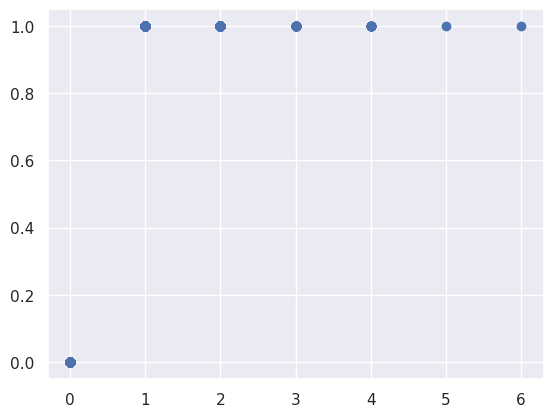

In [81]:
plt.scatter(adata[:,0].X.todense().flat,adata.obsm['positive_pmm_counts'].iloc[:,0])

In [26]:
adata.obsm['counts']=adata.to_df()

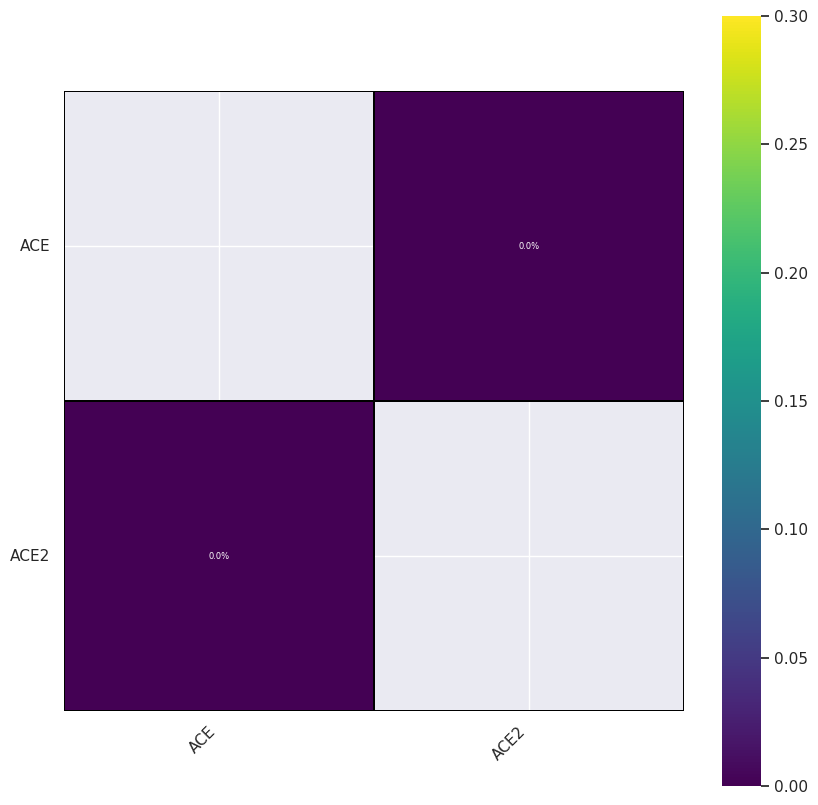

In [32]:
double_positive_pmm(adata,adata.var_names[:2])